In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Generation

In [2]:
true_b = 1
true_w = 2
N = 100

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

In [3]:
# Shuffle indices
idx = np.arange(len(x))
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
test_idx = idx[int(N*.8):]

x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = x[test_idx], y[test_idx]

## Random Initialization

In [4]:
# Step 0 - Initialize parameters b and w randomly
np.random.seed(42)
b = np.random.randn(1)
w = np.random.randn(1)

print(b, w)

[0.49671415] [-0.1382643]


## Compute Model's Predictions

In [5]:
y_hat = b + w * x_train

## Compute the Loss

In [6]:
error = (y_hat - y_train)
loss = (error ** 2).mean()
print(loss)

2.7421577700550976


## Loss Surface

In [7]:
# Reminder:
# true_b = 1
# true_w = 2
# we have to split the ranges in 100 evenly spaced intervals each
b_range = np.linspace(true_b -3, true_b + 3, 101)
w_range = np.linspace(true_w -3, true_w + 3, 101)

bs, ws = np.meshgrid(b_range, w_range)
bs.shape, ws.shape

((101, 101), (101, 101))

In [8]:
dummy_x = x_train[0]
dummy_y_hat = bs + ws * dummy_x
dummy_y_hat.shape

(101, 101)

In [9]:
all_predictions = np.apply_along_axis(
    func1d = lambda x: bs + ws * x,
    axis = 1,
    arr = x_train)
all_predictions.shape

(80, 101, 101)

In [10]:
# reshape labels to allow broadcasting across predict matrix
all_labels = y_train.reshape(-1, 1, 1)
all_labels.shape

(80, 1, 1)

In [11]:
all_errors = (all_predictions - all_labels)
all_errors.shape

(80, 101, 101)

In [12]:
# convert to MSE
all_losses = (all_errors ** 2).mean(axis = 0)
all_losses.shape

(101, 101)

In [13]:
def fit_model(x_train, y_train):
    # Fits a linear regression to find the actual b and w that minimize the loss
    regression = LinearRegression()
    regression.fit(x_train, y_train)
    b_minimum, w_minimum = regression.intercept_[0], regression.coef_[0][0]
    return b_minimum, w_minimum

def find_index(b, w, bs, ws):
    # Looks for the closer indexes for the updated b and w inside their respective ranges
    b_idx = np.argmin(np.abs(bs[0, :] - b))
    w_idx = np.argmin(np.abs(ws[:, 0] - w))

    # Closest values for b and w
    fixedb, fixedw = bs[0, b_idx], ws[w_idx, 0]
    
    return b_idx, w_idx, fixedb, fixedw

Text(0.5, 1.0, 'Loss Surface')

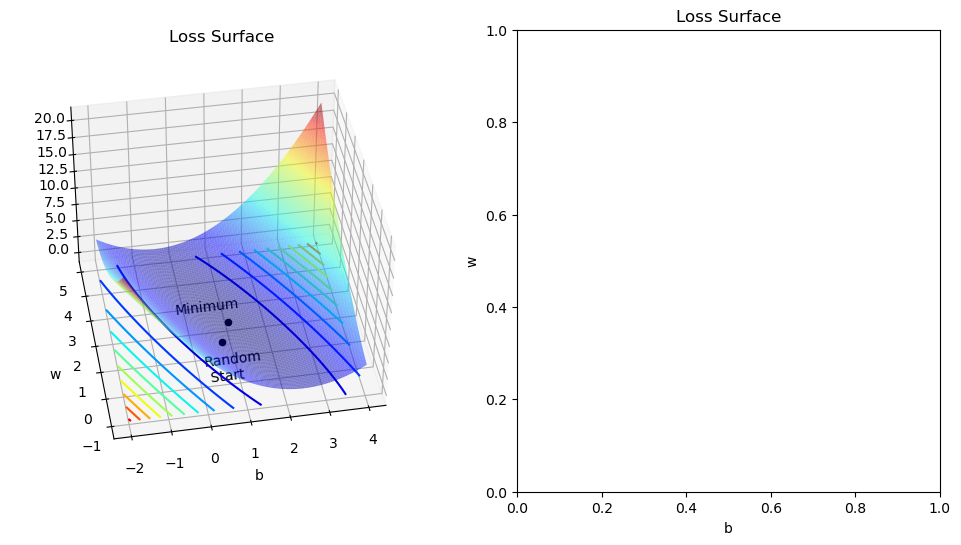

In [14]:
b_minimum, w_minimum = fit_model(x_train, y_train)

figure = plt.figure(figsize=(12, 6))

# 1st plot
ax1 = figure.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel('b')
ax1.set_ylabel('w')
ax1.set_title('Loss Surface')

surf = ax1.plot_surface(bs, ws, all_losses, rstride=1, cstride=1, alpha=.5, cmap=plt.cm.jet, linewidth=0, antialiased=True)
ax1.contour(bs[0, :], ws[:, 0], all_losses, 10, offset=-1, cmap=plt.cm.jet)


bidx, widx, _, _ = find_index(b_minimum, w_minimum, bs, ws)
ax1.scatter(b_minimum, w_minimum, all_losses[bidx, widx], c='k')
ax1.text(-.3, 2.5, all_losses[bidx, widx], 'Minimum', zdir=(1, 0, 0))
# Random start
bidx, widx, _, _ = find_index(b, w, bs, ws)
ax1.scatter(b, w, all_losses[bidx, widx], c='k')
# Annotations
ax1.text(-.2, -1.5, all_losses[bidx, widx], 'Random\n Start', zdir=(1, 0, 0))

ax1.view_init(40, 260)

# 2nd plot
ax2 = figure.add_subplot(1, 2, 2)
ax2.set_xlabel('b')
ax2.set_ylabel('w')
ax2.set_title('Loss Surface')

## Compute Gradient

In [15]:
b_grad = 2 * error.mean()
w_grad = 2 * (x_train * error).mean()
print(b_grad, w_grad)

-3.044811379650508 -1.8337537171510832


## Update Params

In [16]:
lr = 0.1
print(b, w)

b = b - lr * b_grad
w = w - lr * w_grad

print(b, w)

[0.49671415] [-0.1382643]
[0.80119529] [0.04511107]


## Bad Learning Rate Example

In [17]:
true_b = 1
true_w = 2
N = 100
# Data Generation
np.random.seed(42)
# We divide w by 10
bad_w = true_w / 10
# And multiply x by 10
bad_x = np.random.rand(N, 1) * 10
# So, the net effect on y is zero - it is still
# the same as before
y = true_b + bad_w * bad_x + (.1 * np.random.randn(N, 1))
# Generates train and validation sets
# It uses the same train_idx and val_idx as before,
# but it applies to bad_x
bad_x_train, y_train = bad_x[train_idx], y[train_idx]
bad_x_val, y_val = bad_x[test_idx], y[test_idx]

## Standardizing Scales

In [18]:
scaler = StandardScaler(with_mean = True, with_std = True)
# We use the TRAIN set ONLY to fit the scaler
scaler.fit(x_train)

# Now we can use the already fit scaler to TRANSFORM
# both TRAIN and VALIDATION sets
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

1. Always standardize (scale) your features.
2. DO NOT EVER FORGET #1!